In [1]:
import random

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.subplots
import xarray as xr
from dask.distributed import Client, LocalCluster
from deap import algorithms, base, creator, tools
from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    EnvironmentParameter,
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_environment import ClientParameter
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import logger, set_debug, set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

random.seed(64)

In [2]:
xr.set_options(
    keep_attrs=True,
    display_expand_attrs=False,
    display_expand_data=False,
    display_expand_coords=False,
    display_expand_data_vars=False,
)

## DATA


In [3]:
time_start, time_end = "1998-01-01", "2022-01-01"

In [4]:
forcing = xr.open_dataset("../1_1_Forcing/hot_cmems.zarr", engine="zarr")
forcing = forcing.sel(time=slice(time_start, time_end))
forcing["T"].attrs["units"] = "degC"
forcing.load()

<xarray.Dataset> Size: 807kB
Dimensions:              (time: 8767, depth: 3, latitude: 1, longitude: 1)
Coordinates: (4)
Data variables: (13)
Attributes: (10)

In [5]:
cafe_npp = xr.open_dataset("../1_1_Forcing/hot_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.dropna("time")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.lat.attrs = {"units": "degrees_north", "long_name": "latitude", "axis": "Y"}
cafe_npp.lon.attrs = {"units": "degrees_east", "long_name": "longitude", "axis": "X"}
cafe_npp = cafe_npp.rename({"lat": "latitude", "lon": "longitude"})
cafe_npp.load()

<xarray.Dataset> Size: 140kB
Dimensions:    (time: 8767, latitude: 1, longitude: 1)
Coordinates: (3)
Data variables: (1)
Attributes: (5)

In [6]:
obs = xr.open_dataset("../1_1_Forcing/hot_obs.zarr", engine="zarr")
obs.load()

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 659, latitude: 1, longitude: 1, depth: 8, frac: 5)
Coordinates: (5)
Data variables: (24)

## Run seapopym with CAFE npp


In [7]:
tr_max = 10.38
tr_rate = -0.11
inv_lambda_max = 150
inv_lambda_rate = 0.15
day_layer = 1
night_layer = 1
energy_transfert = 0.1668

fgroup = FunctionalGroups(
    functional_groups=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalGroupUnitRelationParameters(
                inv_lambda_max=inv_lambda_max,
                inv_lambda_rate=inv_lambda_rate,
                temperature_recruitment_rate=tr_rate,
                cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                temperature_recruitment_max=tr_max,
            ),
            energy_transfert=energy_transfert,
        )
    ]
)
hot_data_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1),
)
model = NoTransportModel(
    configuration=NoTransportConfiguration(
        parameters=NoTransportParameters(forcing_parameters=hot_data_parameter, functional_groups_parameters=fgroup)
    )
)

2024-07-10 12:59:02,690 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



In [8]:
model.run()

2024-07-10 12:59:02,708 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-07-10 12:59:02,714 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-07-10 12:59:02,725 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-07-10 12:59:02,809 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-07-10 12:59:02,830 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-07-10 12:59:02,836 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-07-10 12:59:02,837 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-07-10 12:59:02,845 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-07-10 12:59:02,870 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-07-10 12:59:02,875 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

## Comparison


/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:338: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



<Axes: xlabel='time'>

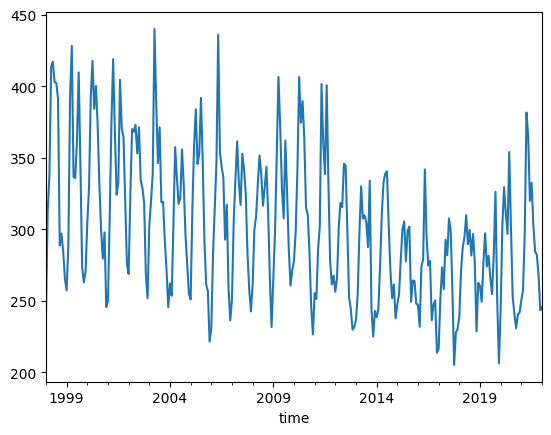

In [24]:
seapodym_zoo = model.export_biomass().pint.quantify().pint.to("mg / meter ** 2")
seapodym_zoo = seapodym_zoo[0, :, 0, 0].rename("prediction")
seapodym_zoo = seapodym_zoo.to_series()
seapodym_zoo = seapodym_zoo.resample("1ME").mean().dropna()
seapodym_zoo.plot()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:338: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



<Axes: xlabel='time'>

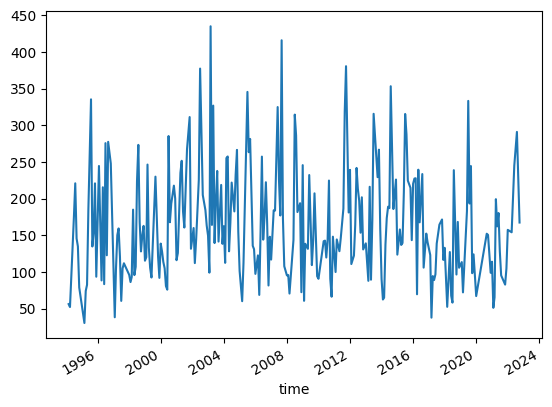

In [25]:
obs_zoo_migrant = obs["dwt_migrant"].sum("frac").mean("depth")
obs_zoo_resident = obs["dwt_resident"].sum("frac").mean("depth")
obs_zoo = obs_zoo_migrant + obs_zoo_resident
obs_zoo = obs_zoo.where(obs_zoo > 0, drop=True).rename("observation")[:, 0, 0]
obs_zoo = obs_zoo.pint.quantify().pint.to("mg / meter ** 2")
obs_zoo = obs_zoo.to_series().resample("1ME").mean().dropna()
obs_zoo.plot()

In [29]:
from plotly import graph_objects as go

# Use plotly to compare obs_zoo and seapopym_zoo in a single plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=obs_zoo.index, y=obs_zoo.values, mode="lines", name="Observation"))
fig.add_trace(go.Scatter(x=seapodym_zoo.index, y=seapodym_zoo.values, mode="lines", name="Seapodym"))

# Change x and y labels
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="Biomass (mg / meter ** 2)")
# add title
fig.update_layout(title="Zooplankton biomass comparison in HOT using CAFE primary production")


fig.show()